In [18]:
import pandas as pd
import numpy as np
import yfinance as yf 
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib 
import pandas_datareader.data as web

In [19]:
ada_data = yf.download('ADA-USD', start='2017-01-01', end='2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [20]:
ada_df = pd.DataFrame(ada_data)

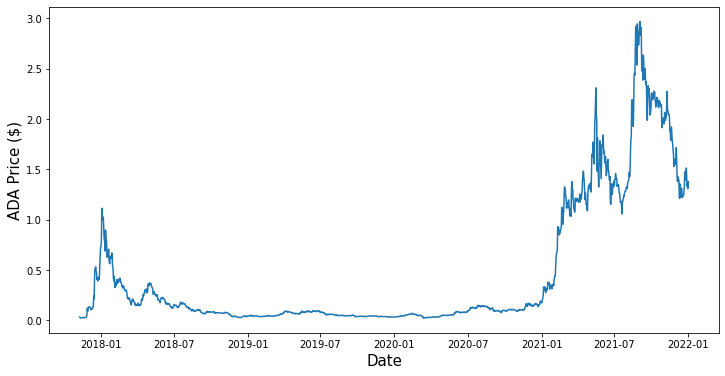

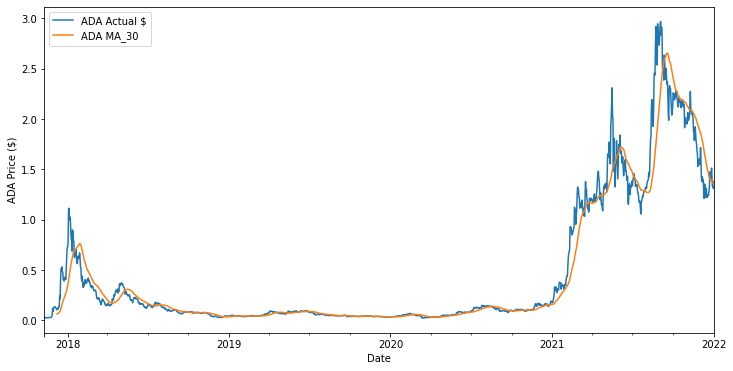

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(ada_df["Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('ADA Price ($)',fontsize=15)
plt.show()

close_px = ada_df['Close']
mavg = close_px.rolling(window=30).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='ADA Actual $')
mavg.plot(label='ADA MA_30')
plt.xlabel('Date')
plt.ylabel('ADA Price ($)')
plt.legend()

In [22]:
import matplotlib.dates as mdates

dates_df = ada_df.copy()
dates_df = dates_df.reset_index()

org_dates = dates_df['Date']

dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1510,738152.0,1.515092,1.537979,1.381352,1.402264,1.402264,2111991275
1511,738153.0,1.401962,1.436113,1.328470,1.330814,1.330814,1516774796
1512,738154.0,1.332747,1.376474,1.300004,1.360415,1.360415,1292798472
1513,738155.0,1.360470,1.379202,1.287365,1.310209,1.310209,1271633462
1514,738156.0,1.310130,1.376975,1.309787,1.376975,1.376975,851279685


In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
prices = np.array(ada_df['Close'])
prices = np.reshape(prices, (-1, 1))

scaler.fit(prices)
prices = scaler.transform(prices)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


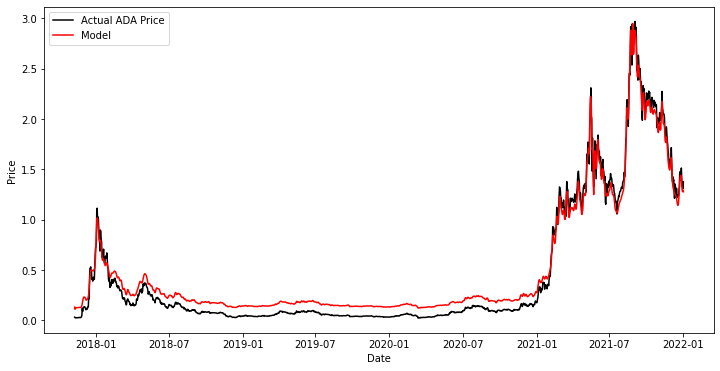

In [24]:
from sklearn.svm import SVR
from sklearn import svm
svr_model = svm.SVR()

dates = np.array(dates_df['Date'])
prices = np.array(ada_df['Close'])

dates = np.reshape(dates, (-1, 1)) 
prices = np.reshape(prices, (-1, 1)) 

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices) 

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Actual ADA Price')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'Model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
train_data = prices
print(train_data.shape)  

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1515, 1)


In [26]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
  
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1479, 36, 1)
X_train:
[[0.032053  ]
 [0.027119  ]
 [0.027437  ]
 [0.023977  ]
 [0.025808  ]
 [0.02623   ]
 [0.026445  ]
 [0.02758   ]
 [0.025773  ]
 [0.026369  ]
 [0.028084  ]
 [0.029581  ]
 [0.02833   ]
 [0.028549  ]
 [0.027444  ]
 [0.028382  ]
 [0.030447  ]
 [0.036332  ]
 [0.050593  ]
 [0.119744  ]
 [0.089718  ]
 [0.119883  ]
 [0.13135201]
 [0.132351  ]
 [0.131807  ]
 [0.13586999]
 [0.127488  ]
 [0.117839  ]
 [0.105501  ]
 [0.115465  ]
 [0.119609  ]
 [0.110281  ]
 [0.121383  ]
 [0.133891  ]
 [0.13428099]
 [0.240753  ]]


y_train: [[0.213467]]



In [27]:
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
104/104 [==============================] - 10s 58ms/step - loss: 5.3744e-04 - val_loss: 0.0110
Epoch 2/20
104/104 [==============================] - 5s 50ms/step - loss: 3.0177e-04 - val_loss: 0.0021
Epoch 3/20
104/104 [==============================] - 5s 51ms/step - loss: 2.7008e-04 - val_loss: 0.0042
Epoch 4/20
104/104 [==============================] - 5s 50ms/step - loss: 2.6738e-04 - val_loss: 0.0052
Epoch 5/20
104/104 [==============================] - 5s 50ms/step - loss: 2.3327e-04 - val_loss: 0.0035
Epoch 6/20
104/104 [==============================] - 5s 50ms/step - loss: 1.6483e-04 - val_loss: 0.0071
Epoch 7/20
104/104 [==============================] - 7s 70ms/step - loss: 1.9222e-04 - val_loss: 0.0060
Epoch 8/20
104/104 [==============================] - 5s 50ms/step - loss: 1.6845e-04 - val_loss: 0.0016
Epoch 9/20
104/104 [==============================] - 5s 50ms/step - loss: 1.4397e-04 - val_loss: 0.0029
Epoch 10/20
104/104 [==============================] -

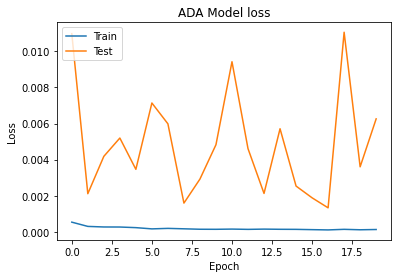

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ADA Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
model.evaluate(X_train, y_train)

47/47 [==============================] - 1s 21ms/step - loss: 0.0019


0.0019355713156983256

In [30]:
predicted = model.predict(X_train)

In [31]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

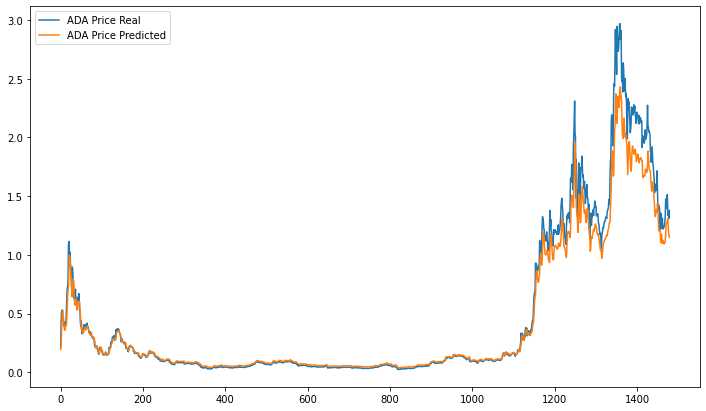

In [32]:
stocks = pd.DataFrame({
    'ADA Price Real': real_prices.ravel(),
    'ADA Price Predicted': predicted_prices.ravel()},
)
stocks.head()

stocks.plot(figsize=(12,7))